Task 2: Training from scratch
- development of a classification model for discriminating between 2 classes: fruits and vegetables;
- development of a classification model for discriminating between subclasses of each parent class.

### Authentication and enabling GPU

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Tensorflow is already installed in Colab
# check if tensorflow is installed
import tensorflow as tf
print(tf.__version__) 
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('you must enable GPU! Go to:')
  print('\nRuntime')
  print('\tChange runtime type')
  print('\t\tHardware Accelerator: GPU')

  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.7.0
Found GPU at: /device:GPU:0


### Global libraries and utility



In [ ]:
import os
import os.path
import timeit
import datetime
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import tensorflow as tf
from pathlib import Path
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import models
from tensorflow.keras import layers
from keras.regularizers import l2, l1
from tensorflow.keras import regularizers
from tensorflow.python.framework import ops
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory



#magic command for enabling tensorflow 1.x
#%tensorflow_version 1.x 

# print tensorflow and keras versions
print(tf.__version__)
print(keras.__version__)





2.7.0
2.7.0


In [ ]:
def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """
    
    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [ ]:

def get_training_learning_dataframes(df_dataset,numberTests = 5):

  df_unique_labels = df_dataset.copy().drop_duplicates(subset=["Label"]).reset_index()
  list_labels = df_unique_labels["Label"].tolist()


  df_test = pd.DataFrame(columns=['Filepath','Label'])
  df_training = pd.DataFrame(columns=['Filepath','Label'])
  cum_indices = []

  for etichetta in list_labels:
    list_indices = df_dataset[(df_dataset.Label==etichetta)].index
    indices = [ list_indices[j] for j in range(numberTests)] #get only the first 'numberTests' indices of a set of samples for a specific class


    for elem in indices:
      cum_indices.append(elem)

    df_tmp = pd.DataFrame(df_dataset.iloc[indices])
    df_test = pd.concat([df_test,df_tmp],ignore_index = True, axis = 0)


  cum_indices.sort()

  df_training = df_dataset.iloc[~df_dataset.index.isin(cum_indices)] 
  df_training.reset_index(drop=True, inplace=True)

  return df_training,df_test






In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal"), 
    layers.RandomRotation(0.2), 
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode="constant", fill_value=255),
    layers.RandomZoom(0.1, fill_mode="nearest") 
  ]
)

In [ ]:
BATCH_SIZE = 36 
NUMBER_CLASSES = 33
PATIENCE = 20 
IMAGE_HEIGHT = 180
IMAGE_WIDTH = 180
EPOCH = 40

PATH_DATASET = '/content/drive/Shareddrives/CIDL/dataset/preprocessed'
PATH_DATASET_PROVA = '/content/drive/Shareddrives/CIDL/dataset/preprocessedProva'
PATH_HOME = '/content/drive/Shareddrives/CIDL/'

###Loading dataset

In [ ]:
# Create a list with the filepaths for training and testing
dataset_dir = Path(PATH_DATASET)
dataset_filepaths = list(dataset_dir.glob(r'**/*.jpg'))


df_dataset = proc_img(dataset_filepaths)
df_training,df_test = get_training_learning_dataframes(df_dataset)

In [ ]:

train_datagenerator = ImageDataGenerator(
       rescale= 1. / 255.0,
       validation_split=0.20
)

test_datagenerator = ImageDataGenerator(rescale= 1. / 255.0) # <- con questo rescale le immagini venivano nere e la rete prediceva una classse sola mah...

In [ ]:
train_images = train_datagenerator.flow_from_dataframe(
    dataframe=df_training,
    x_col='Filepath',
    y_col='Label',
    subset= "training",
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=0,
)

val_images = train_datagenerator.flow_from_dataframe(
    dataframe=df_training,
    x_col='Filepath',
    y_col='Label',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    subset= "validation",
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=0,
)


test_images = test_datagenerator.flow_from_dataframe(
    dataframe=df_test,
    x_col='Filepath',
    y_col='Label',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    color_mode='rgb',
    class_mode='categorical',
    seed=0,
    batch_size=1,
    shuffle=False   
)

Found 1729 validated image filenames belonging to 33 classes.
Found 432 validated image filenames belonging to 33 classes.
Found 165 validated image filenames belonging to 33 classes.


### Model 0 - base

In [ ]:
#NETWORK ARCHITECTURE

inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
outputs = layers.Dense(NUMBER_CLASSES, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 118336)            0     

In [ ]:
PATH_HOME = '/content/drive/Shareddrives/CIDL/'
dir_name = PATH_HOME + "/models"
model_name = 'model0-scratch-multiclass.h5'
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,model_name)



earlyStopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=PATIENCE,
                restore_best_weights=True)
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=30,
    callbacks = [earlyStopping, modelCheckpoint]
)


Epoch 1/30
20/49 [===========>..................] - ETA: 9:09 - loss: 4.5166 - accuracy: 0.0458

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


22/49 [============>.................] - ETA: 8:34 - loss: 4.4029 - accuracy: 0.0492

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


49/49 [==============================] - ETA: 0s - loss: 3.6843 - accuracy: 0.1122 
Epoch 00001: val_loss improved from inf to 2.89244, saving model to /content/drive/Shareddrives/CIDL//models/model0-scratch-multiclass.h5
49/49 [==============================] - 1189s 24s/step - loss: 3.6843 - accuracy: 0.1122 - val_loss: 2.8924 - val_accuracy: 0.1713
Epoch 2/30
49/49 [==============================] - ETA: 0s - loss: 2.0892 - accuracy: 0.4153
Epoch 00002: val_loss improved from 2.89244 to 2.50578, saving model to /content/drive/Shareddrives/CIDL//models/model0-scratch-multiclass.h5
49/49 [==============================] - 88s 2s/step - loss: 2.0892 - accuracy: 0.4153 - val_loss: 2.5058 - val_accuracy: 0.2685
Epoch 3/30
49/49 [==============================] - ETA: 0s - loss: 1.0050 - accuracy: 0.7305
Epoch 00003: val_loss did not improve from 2.50578
49/49 [==============================] - 88s 2s/step - loss: 1.0050 - accuracy: 0.7305 - val_loss: 2.8211 - val_accuracy: 0.3009
Epoch 4

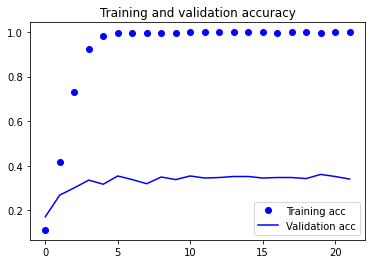

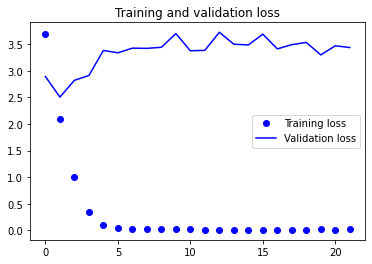

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

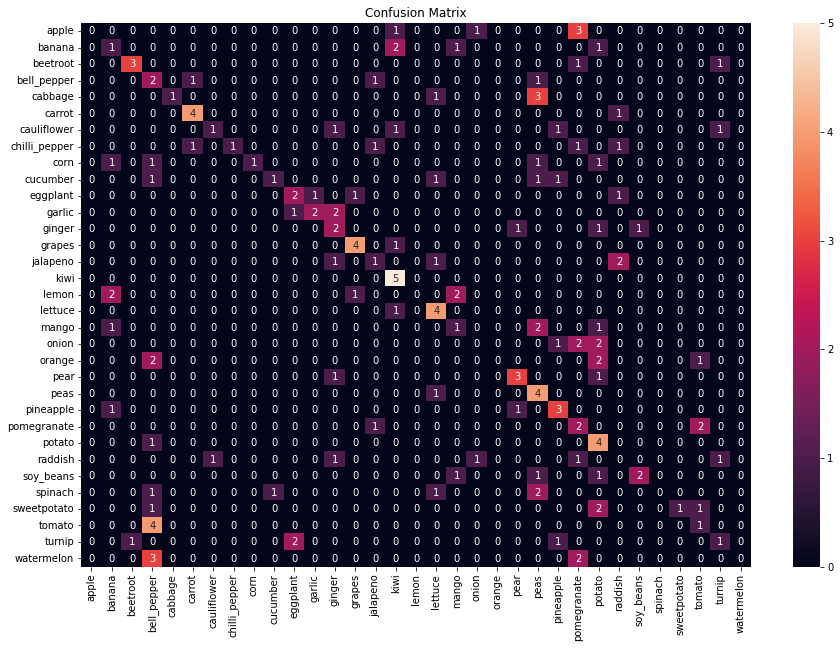

In [ ]:
cf_matrix = confusion_matrix(y_test, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Confusion Matrix')
plt.show()

###Model 1


In [ ]:
#NETWORK ARCHITECTURE

inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
outputs = layers.Dense(NUMBER_CLASSES, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d_22 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 43, 43, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 41, 41, 64)        1849

In [ ]:
PATH_HOME = '/content/drive/Shareddrives/CIDL/'
dir_name = PATH_HOME + "/models"
model_name = 'model1-scratch-multiclass.h5'
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,model_name)



earlyStopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True)
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=EPOCH,
    callbacks = [earlyStopping, modelCheckpoint]
)


Epoch 1/40
35/48 [====================>.........] - ETA: 20s - loss: 3.4426 - accuracy: 0.0683

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


47/48 [============================>.] - ETA: 1s - loss: 3.3944 - accuracy: 0.0674

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


48/48 [==============================] - ETA: 0s - loss: 3.3878 - accuracy: 0.0700
Epoch 00001: val_loss improved from inf to 3.13094, saving model to /content/drive/Shareddrives/CIDL//models/model1-scratch-multiclass.h5
48/48 [==============================] - 97s 2s/step - loss: 3.3878 - accuracy: 0.0700 - val_loss: 3.1309 - val_accuracy: 0.0926
Epoch 2/40
48/48 [==============================] - ETA: 0s - loss: 2.8114 - accuracy: 0.1707
Epoch 00002: val_loss improved from 3.13094 to 2.52311, saving model to /content/drive/Shareddrives/CIDL//models/model1-scratch-multiclass.h5
48/48 [==============================] - 94s 2s/step - loss: 2.8114 - accuracy: 0.1707 - val_loss: 2.5231 - val_accuracy: 0.2917
Epoch 3/40
48/48 [==============================] - ETA: 0s - loss: 2.3003 - accuracy: 0.2934
Epoch 00003: val_loss improved from 2.52311 to 2.37037, saving model to /content/drive/Shareddrives/CIDL//models/model1-scratch-multiclass.h5
48/48 [==============================] - 95s 2s/s

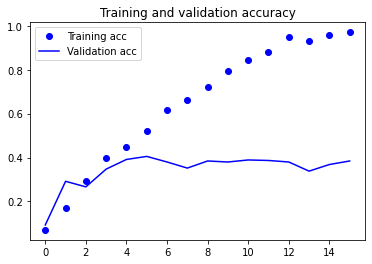

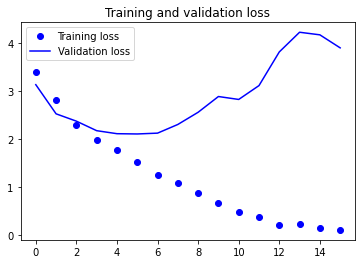

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 34.55%


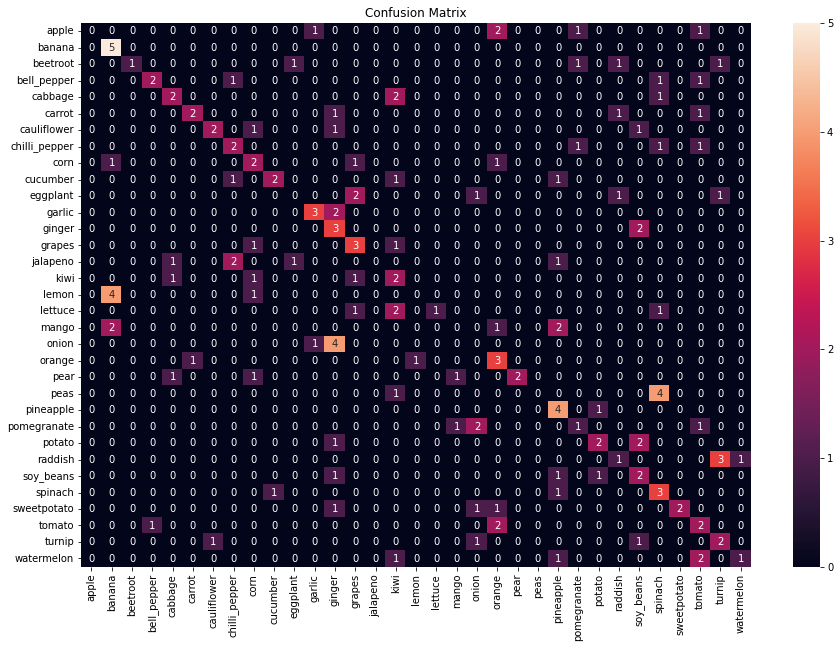

In [ ]:
cf_matrix = confusion_matrix(y_test, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Confusion Matrix')
plt.show()

### Model 2

In [ ]:
#NETWORK ARCHITECTURE

inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x) 
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)  #<----------- Added Convolutional Layer and increased filter dimension
x = layers.MaxPooling2D(pool_size=2)(x)  
x = layers.Flatten()(x)
outputs = layers.Dense(NUMBER_CLASSES, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d_25 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 43, 43, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 41, 41, 64)        1849

In [ ]:
PATH_HOME = '/content/drive/Shareddrives/CIDL/'
dir_name = PATH_HOME + "/models"
model_name = 'model2-scratch-multiclass.h5'
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,model_name)



earlyStopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True)
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=EPOCH,
    callbacks = [earlyStopping, modelCheckpoint]
)


Epoch 1/40
 1/48 [..............................] - ETA: 1:20 - loss: 3.3931 - accuracy: 0.0833

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


 2/48 [>.............................] - ETA: 1:15 - loss: 3.4282 - accuracy: 0.0833

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


48/48 [==============================] - ETA: 0s - loss: 3.2033 - accuracy: 0.0955
Epoch 00001: val_loss improved from inf to 2.78306, saving model to /content/drive/Shareddrives/CIDL//models/model2-scratch-multiclass.h5
48/48 [==============================] - 82s 2s/step - loss: 3.2033 - accuracy: 0.0955 - val_loss: 2.7831 - val_accuracy: 0.1389
Epoch 2/40
48/48 [==============================] - ETA: 0s - loss: 2.5922 - accuracy: 0.2014
Epoch 00002: val_loss improved from 2.78306 to 2.50691, saving model to /content/drive/Shareddrives/CIDL//models/model2-scratch-multiclass.h5
48/48 [==============================] - 80s 2s/step - loss: 2.5922 - accuracy: 0.2014 - val_loss: 2.5069 - val_accuracy: 0.2384
Epoch 3/40
48/48 [==============================] - ETA: 0s - loss: 2.3408 - accuracy: 0.2824
Epoch 00003: val_loss improved from 2.50691 to 2.32667, saving model to /content/drive/Shareddrives/CIDL//models/model2-scratch-multiclass.h5
48/48 [==============================] - 81s 2s/s

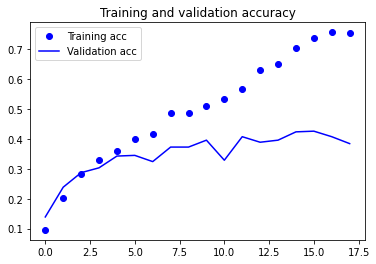

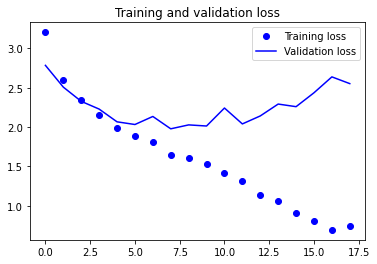

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 37.58%


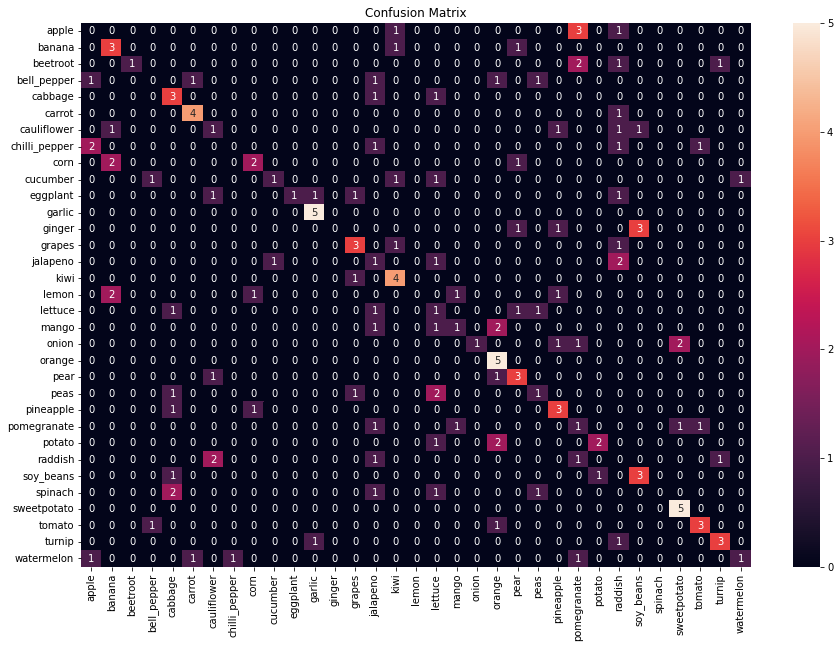

In [ ]:
cf_matrix = confusion_matrix(y_test, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Confusion Matrix')
plt.show()

### Model 3

In [ ]:
#NETWORK ARCHITECTURE

inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
outputs = layers.Dense(NUMBER_CLASSES, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 conv2d_42 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 43, 43, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 41, 41, 64)        184

In [ ]:
PATH_HOME = '/content/drive/Shareddrives/CIDL/'
dir_name = PATH_HOME + "/models"
model_name = 'model3-scratch-multiclass.h5'
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,model_name)



earlyStopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True)
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=EPOCH,
    callbacks = [earlyStopping, modelCheckpoint]
)


Epoch 1/40
10/48 [=====>........................] - ETA: 44s - loss: 3.4840 - accuracy: 0.0278

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


42/48 [=========================>....] - ETA: 8s - loss: 3.2524 - accuracy: 0.0787

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


48/48 [==============================] - ETA: 0s - loss: 3.2077 - accuracy: 0.0856
Epoch 00001: val_loss improved from inf to 2.69879, saving model to /content/drive/Shareddrives/CIDL//models/model2_2-scratch-multiclass.h5
48/48 [==============================] - 82s 2s/step - loss: 3.2077 - accuracy: 0.0856 - val_loss: 2.6988 - val_accuracy: 0.2222
Epoch 2/40
48/48 [==============================] - ETA: 0s - loss: 2.5095 - accuracy: 0.2512
Epoch 00002: val_loss improved from 2.69879 to 2.35598, saving model to /content/drive/Shareddrives/CIDL//models/model2_2-scratch-multiclass.h5
48/48 [==============================] - 81s 2s/step - loss: 2.5095 - accuracy: 0.2512 - val_loss: 2.3560 - val_accuracy: 0.2778
Epoch 3/40
48/48 [==============================] - ETA: 0s - loss: 2.0942 - accuracy: 0.3571
Epoch 00003: val_loss improved from 2.35598 to 2.24514, saving model to /content/drive/Shareddrives/CIDL//models/model2_2-scratch-multiclass.h5
48/48 [==============================] - 80

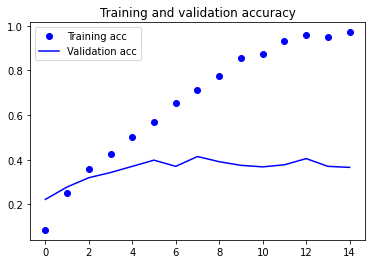

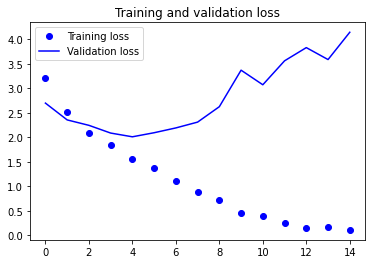

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 36.36%


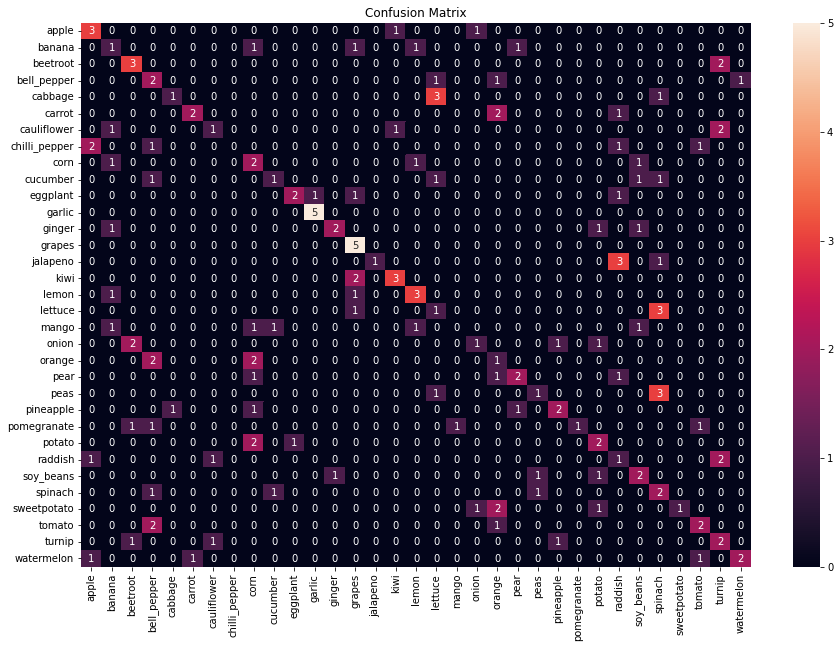

In [ ]:
cf_matrix = confusion_matrix(y_test, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Confusion Matrix')
plt.show()

###Model 4

In [ ]:
#NETWORK ARCHITECTURE

inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)  
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
outputs = layers.Dense(NUMBER_CLASSES, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 conv2d_51 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_52 (Conv2D)          (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 43, 43, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_53 (Conv2D)          (None, 41, 41, 64)        184

In [ ]:
PATH_HOME = '/content/drive/Shareddrives/CIDL/'
dir_name = PATH_HOME + "/models"
model_name = 'model4-scratch-multiclass.h5'
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,model_name)



earlyStopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True)
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=EPOCH,
    callbacks = [earlyStopping, modelCheckpoint]
)


Epoch 1/40
14/48 [=======>......................] - ETA: 45s - loss: 3.4635 - accuracy: 0.0575

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


34/48 [====================>.........] - ETA: 19s - loss: 3.3411 - accuracy: 0.0686

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


48/48 [==============================] - ETA: 0s - loss: 3.2865 - accuracy: 0.0718
Epoch 00001: val_loss improved from inf to 3.04844, saving model to /content/drive/Shareddrives/CIDL//models/model2_3-scratch-multiclass.h5
48/48 [==============================] - 82s 2s/step - loss: 3.2865 - accuracy: 0.0718 - val_loss: 3.0484 - val_accuracy: 0.1366
Epoch 2/40
48/48 [==============================] - ETA: 0s - loss: 2.7423 - accuracy: 0.1759
Epoch 00002: val_loss improved from 3.04844 to 2.48705, saving model to /content/drive/Shareddrives/CIDL//models/model2_3-scratch-multiclass.h5
48/48 [==============================] - 81s 2s/step - loss: 2.7423 - accuracy: 0.1759 - val_loss: 2.4871 - val_accuracy: 0.2014
Epoch 3/40
48/48 [==============================] - ETA: 0s - loss: 2.3587 - accuracy: 0.2529
Epoch 00003: val_loss improved from 2.48705 to 2.29135, saving model to /content/drive/Shareddrives/CIDL//models/model2_3-scratch-multiclass.h5
48/48 [==============================] - 81

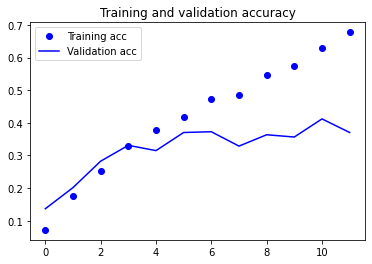

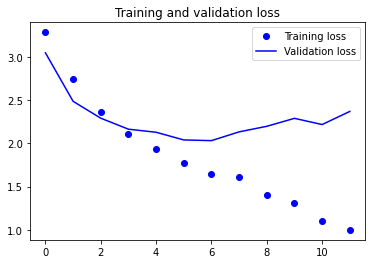

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 31.52%


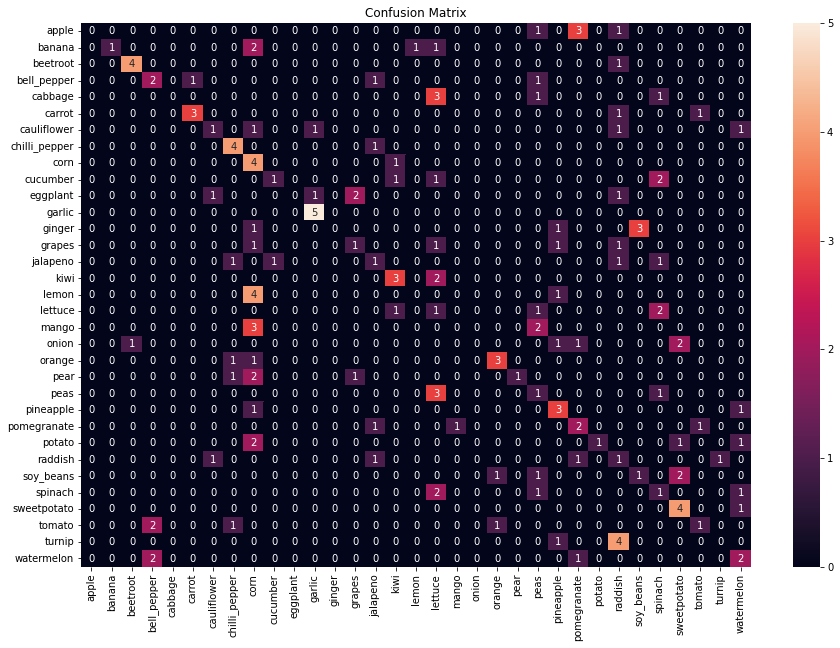

In [ ]:
cf_matrix = confusion_matrix(y_test, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Confusion Matrix')
plt.show()

### Model 1_1

In [ ]:
#NETWORK ARCHITECTURE

inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x) 
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)   #<----- Added Hidden Layer into output network
outputs = layers.Dense(NUMBER_CLASSES, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()


Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 conv2d_38 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_39 (Conv2D)          (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 43, 43, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 41, 41, 64)        1849

In [ ]:
PATH_HOME = '/content/drive/Shareddrives/CIDL/'
dir_name = PATH_HOME + "/models"
model_name = 'model1_1-scratch-multiclass.h5'
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,model_name)



earlyStopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True)
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=EPOCH,
    callbacks = [earlyStopping, modelCheckpoint]
)


Epoch 1/40
 9/48 [====>.........................] - ETA: 50s - loss: 3.4928 - accuracy: 0.0556

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


38/48 [======================>.......] - ETA: 13s - loss: 3.3278 - accuracy: 0.0716

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


48/48 [==============================] - ETA: 0s - loss: 3.2427 - accuracy: 0.0816
Epoch 00001: val_loss improved from inf to 2.85865, saving model to /content/drive/Shareddrives/CIDL//models/model2_1-scratch-multiclass.h5
48/48 [==============================] - 84s 2s/step - loss: 3.2427 - accuracy: 0.0816 - val_loss: 2.8587 - val_accuracy: 0.1644
Epoch 2/40
48/48 [==============================] - ETA: 0s - loss: 2.6110 - accuracy: 0.2193
Epoch 00002: val_loss improved from 2.85865 to 2.37857, saving model to /content/drive/Shareddrives/CIDL//models/model2_1-scratch-multiclass.h5
48/48 [==============================] - 81s 2s/step - loss: 2.6110 - accuracy: 0.2193 - val_loss: 2.3786 - val_accuracy: 0.2778
Epoch 3/40
48/48 [==============================] - ETA: 0s - loss: 2.1984 - accuracy: 0.3281
Epoch 00003: val_loss improved from 2.37857 to 2.18493, saving model to /content/drive/Shareddrives/CIDL//models/model2_1-scratch-multiclass.h5
48/48 [==============================] - 82

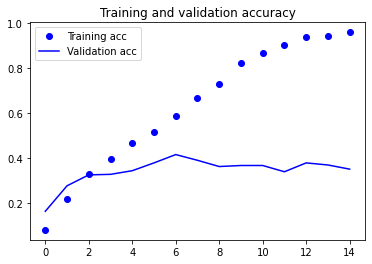

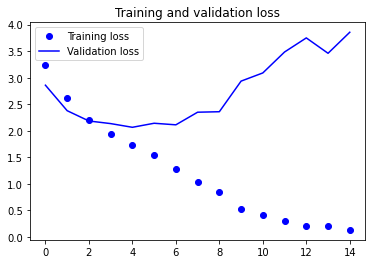

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 35.15%


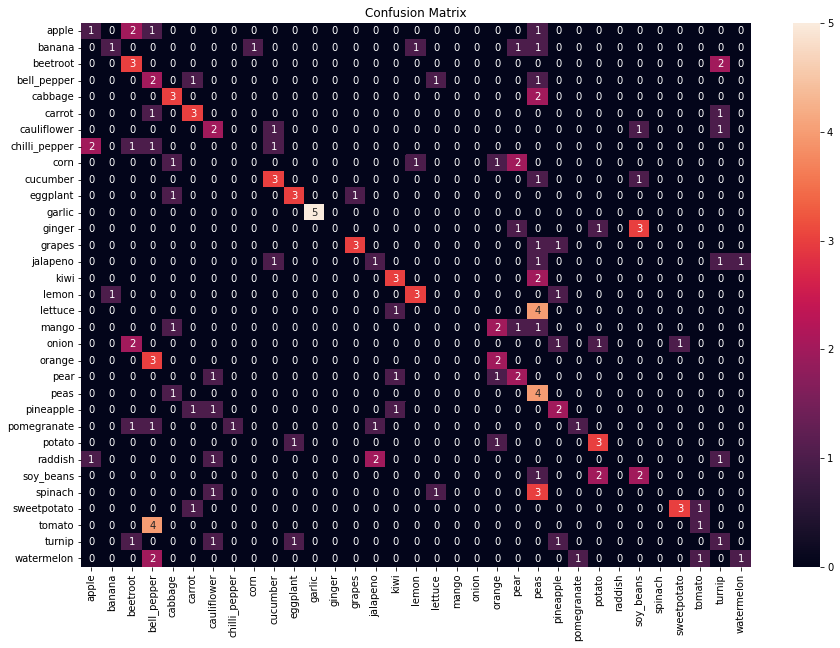

In [ ]:
cf_matrix = confusion_matrix(y_test, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Confusion Matrix')
plt.show()

### Model 1_2 

In [ ]:
#NETWORK ARCHITECTURE

inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x) 
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)   #<----- Added Hidden Layer into output network
outputs = layers.Dense(NUMBER_CLASSES, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 41, 41, 64)        1849

In [ ]:
PATH_HOME = '/content/drive/Shareddrives/CIDL/'
dir_name = PATH_HOME + "/models"
model_name = 'model1_2-scratch-multiclass.h5'
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,model_name)



earlyStopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True)
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=EPOCH,
    callbacks = [earlyStopping, modelCheckpoint]
)


Epoch 1/40
25/49 [==============>...............] - ETA: 35s - loss: 3.4386 - accuracy: 0.0879

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


38/49 [======================>.......] - ETA: 15s - loss: 3.3659 - accuracy: 0.0795

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


49/49 [==============================] - ETA: 0s - loss: 3.2870 - accuracy: 0.0908
Epoch 00001: val_loss improved from inf to 2.99804, saving model to /content/drive/Shareddrives/CIDL//models/model1_2-scratch-multiclass.h5
49/49 [==============================] - 90s 2s/step - loss: 3.2870 - accuracy: 0.0908 - val_loss: 2.9980 - val_accuracy: 0.1435
Epoch 2/40
49/49 [==============================] - ETA: 0s - loss: 2.7146 - accuracy: 0.2117
Epoch 00002: val_loss improved from 2.99804 to 2.54172, saving model to /content/drive/Shareddrives/CIDL//models/model1_2-scratch-multiclass.h5
49/49 [==============================] - 89s 2s/step - loss: 2.7146 - accuracy: 0.2117 - val_loss: 2.5417 - val_accuracy: 0.2153
Epoch 3/40
49/49 [==============================] - ETA: 0s - loss: 2.2883 - accuracy: 0.2967
Epoch 00003: val_loss improved from 2.54172 to 2.48566, saving model to /content/drive/Shareddrives/CIDL//models/model1_2-scratch-multiclass.h5
49/49 [==============================] - 92

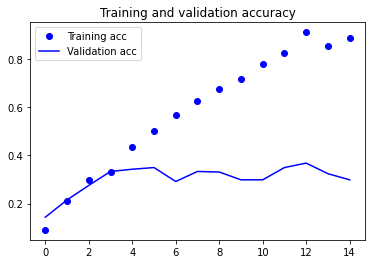

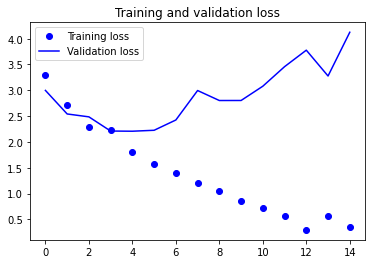

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 31.52%


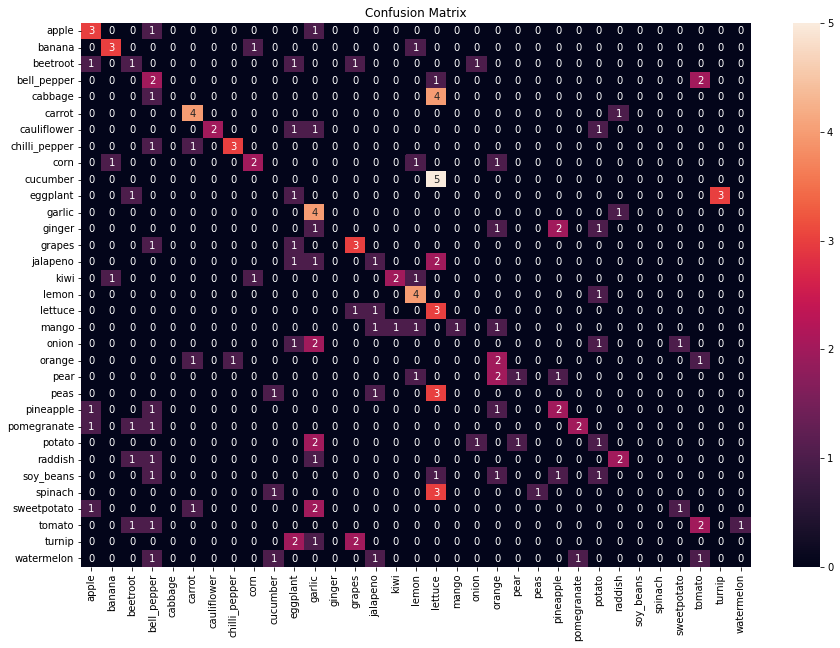

In [ ]:
cf_matrix = confusion_matrix(y_test, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Confusion Matrix')
plt.show()

###Model 1a

In [ ]:
#NETWORK ARCHITECTURE

inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = data_augmentation(inputs)                                               #<------ Input augmented
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
outputs = layers.Dense(NUMBER_CLASSES, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 43, 43, 32)       0         
 g2D)                                                      

In [ ]:
PATH_HOME = '/content/drive/Shareddrives/CIDL/'
dir_name = PATH_HOME + "/models"
model_name = 'model1a-scratch-multiclass.h5'
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,model_name)



earlyStopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=PATIENCE,
                restore_best_weights=True)
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=60,
    callbacks = [earlyStopping, modelCheckpoint]
)


Epoch 1/60
19/48 [==========>...................] - ETA: 46s - loss: 5.7980 - accuracy: 0.0292

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


27/48 [===============>..............] - ETA: 33s - loss: 5.1196 - accuracy: 0.0288

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


48/48 [==============================] - ETA: 0s - loss: 4.4104 - accuracy: 0.0353
Epoch 00001: val_loss improved from inf to 3.49408, saving model to /content/drive/Shareddrives/CIDL//models/model4_1-scratch-multiclass.h5
48/48 [==============================] - 97s 2s/step - loss: 4.4104 - accuracy: 0.0353 - val_loss: 3.4941 - val_accuracy: 0.0671
Epoch 2/60
48/48 [==============================] - ETA: 0s - loss: 3.4823 - accuracy: 0.0573
Epoch 00002: val_loss improved from 3.49408 to 3.46442, saving model to /content/drive/Shareddrives/CIDL//models/model4_1-scratch-multiclass.h5
48/48 [==============================] - 95s 2s/step - loss: 3.4823 - accuracy: 0.0573 - val_loss: 3.4644 - val_accuracy: 0.0648
Epoch 3/60
48/48 [==============================] - ETA: 0s - loss: 3.3454 - accuracy: 0.0677
Epoch 00003: val_loss improved from 3.46442 to 3.28544, saving model to /content/drive/Shareddrives/CIDL//models/model4_1-scratch-multiclass.h5
48/48 [==============================] - 95

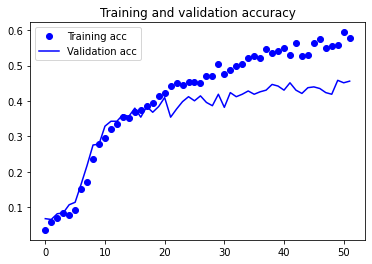

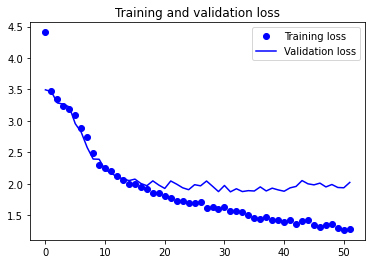

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 40.00%


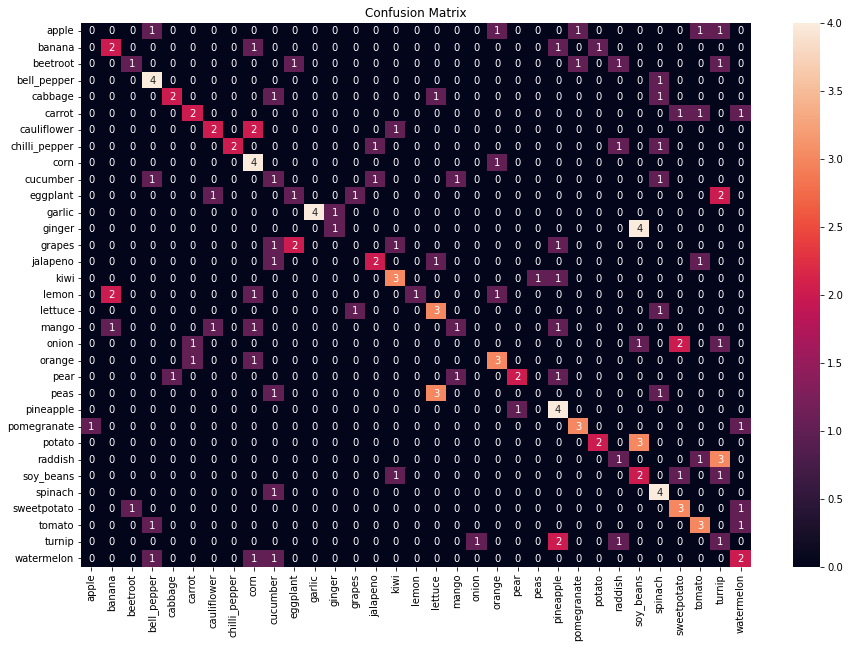

In [ ]:
cf_matrix = confusion_matrix(y_test, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#NETWORK ARCHITECTURE

inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)

outputs = layers.Dense(NUMBER_CLASSES, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d_15 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 41, 41, 128)       7385

In [ ]:
PATH_HOME = '/content/drive/Shareddrives/CIDL/'
dir_name = PATH_HOME + "/models"
model_name = 'model4-scratch-multiclass.h5'
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,model_name)



earlyStopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=PATIENCE,
                restore_best_weights=True)
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=EPOCH,
    callbacks = [earlyStopping, modelCheckpoint]
)


Epoch 1/20
17/87 [====>.........................] - ETA: 55s - loss: 3.5014 - accuracy: 0.0618

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


44/87 [==============>...............] - ETA: 34s - loss: 3.4483 - accuracy: 0.0495

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


87/87 [==============================] - ETA: 0s - loss: 3.3050 - accuracy: 0.0602
Epoch 00001: val_loss improved from inf to 3.01825, saving model to /content/drive/Shareddrives/CIDL//models/model4-scratch-multiclass.h5
87/87 [==============================] - 94s 1s/step - loss: 3.3050 - accuracy: 0.0602 - val_loss: 3.0182 - val_accuracy: 0.0856
Epoch 2/20
87/87 [==============================] - ETA: 0s - loss: 2.9810 - accuracy: 0.1273
Epoch 00002: val_loss improved from 3.01825 to 2.79231, saving model to /content/drive/Shareddrives/CIDL//models/model4-scratch-multiclass.h5
87/87 [==============================] - 90s 1s/step - loss: 2.9810 - accuracy: 0.1273 - val_loss: 2.7923 - val_accuracy: 0.1782
Epoch 3/20
87/87 [==============================] - ETA: 0s - loss: 2.6914 - accuracy: 0.1858
Epoch 00003: val_loss improved from 2.79231 to 2.76848, saving model to /content/drive/Shareddrives/CIDL//models/model4-scratch-multiclass.h5
87/87 [==============================] - 89s 1s/s

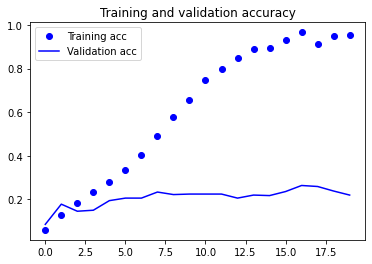

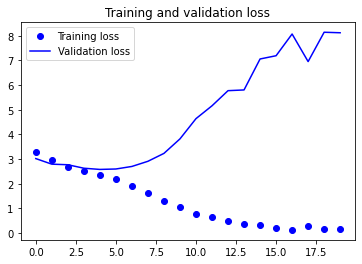

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 29.09%


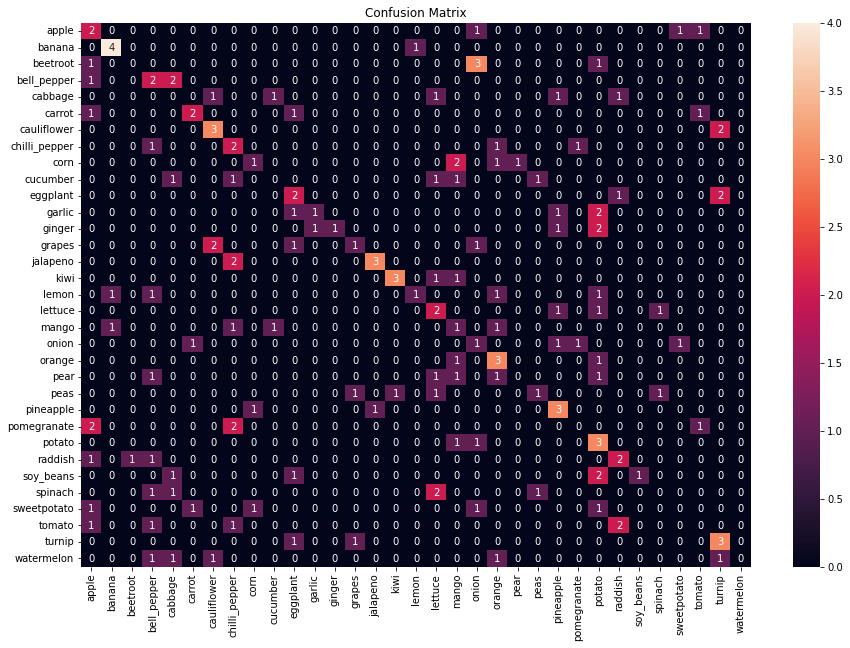

In [ ]:
cf_matrix = confusion_matrix(y_test, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Confusion Matrix')
plt.show()

###Model 2_1

In [ ]:
#Riprendo il model 2

#NETWORK ARCHITECTURE

inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x) 
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)  
x = layers.MaxPooling2D(pool_size=2)(x)  
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)   #<----- Added Hidden Layer into output network
outputs = layers.Dense(NUMBER_CLASSES, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 64)        18496 

In [ ]:
PATH_HOME = '/content/drive/Shareddrives/CIDL/'
dir_name = PATH_HOME + "/models"
model_name = 'model2_2-scratch-multiclass.h5'
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,model_name)



earlyStopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True)
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=EPOCH,
    callbacks = [earlyStopping, modelCheckpoint]
)


Epoch 1/40
 9/48 [====>.........................] - ETA: 7:17 - loss: 3.4981 - accuracy: 0.0185

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


39/48 [=======================>......] - ETA: 1:43 - loss: 3.4366 - accuracy: 0.0392

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


48/48 [==============================] - ETA: 0s - loss: 3.3744 - accuracy: 0.0521 
Epoch 00001: val_loss improved from inf to 3.10864, saving model to /content/drive/Shareddrives/CIDL//models/model3-scratch-multiclass.h5
48/48 [==============================] - 705s 15s/step - loss: 3.3744 - accuracy: 0.0521 - val_loss: 3.1086 - val_accuracy: 0.1227
Epoch 2/40
48/48 [==============================] - ETA: 0s - loss: 2.8382 - accuracy: 0.1487
Epoch 00002: val_loss improved from 3.10864 to 2.63572, saving model to /content/drive/Shareddrives/CIDL//models/model3-scratch-multiclass.h5
48/48 [==============================] - 96s 2s/step - loss: 2.8382 - accuracy: 0.1487 - val_loss: 2.6357 - val_accuracy: 0.2269
Epoch 3/40
48/48 [==============================] - ETA: 0s - loss: 2.4817 - accuracy: 0.2373
Epoch 00003: val_loss improved from 2.63572 to 2.47312, saving model to /content/drive/Shareddrives/CIDL//models/model3-scratch-multiclass.h5
48/48 [==============================] - 96s 2

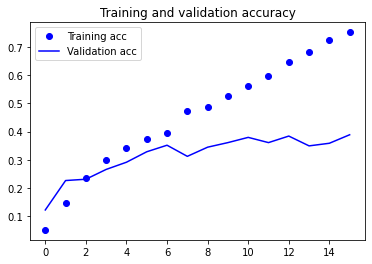

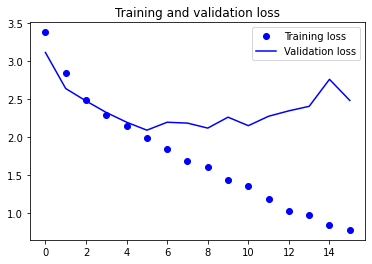

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 35.15%


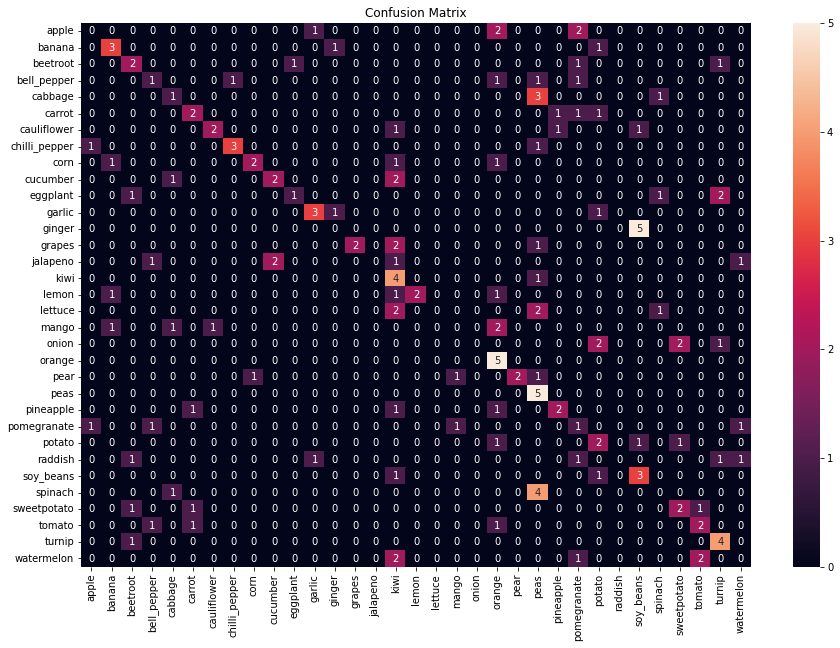

In [ ]:
cf_matrix = confusion_matrix(y_test, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Confusion Matrix')
plt.show()

###Model 2_2

In [ ]:
#Riprendo il model 2

#NETWORK ARCHITECTURE

inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x) 
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)  
x = layers.MaxPooling2D(pool_size=2)(x)  
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)   #<----- Added Hidden Layer into output network
outputs = layers.Dense(NUMBER_CLASSES, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 41, 41, 64)        1849

In [ ]:
PATH_HOME = '/content/drive/Shareddrives/CIDL/'
dir_name = PATH_HOME + "/models"
model_name = 'model3_1-scratch-multiclass.h5'
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,model_name)



earlyStopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True)
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=EPOCH,
    callbacks = [earlyStopping, modelCheckpoint]
)


Epoch 1/40
 3/48 [>.............................] - ETA: 1:03 - loss: 3.5029 - accuracy: 0.0556

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


34/48 [====================>.........] - ETA: 22s - loss: 3.4408 - accuracy: 0.0507

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


48/48 [==============================] - ETA: 0s - loss: 3.3996 - accuracy: 0.0550
Epoch 00001: val_loss improved from inf to 3.20924, saving model to /content/drive/Shareddrives/CIDL//models/model3_1-scratch-multiclass.h5
48/48 [==============================] - 99s 2s/step - loss: 3.3996 - accuracy: 0.0550 - val_loss: 3.2092 - val_accuracy: 0.0856
Epoch 2/40
48/48 [==============================] - ETA: 0s - loss: 3.0968 - accuracy: 0.0747
Epoch 00002: val_loss improved from 3.20924 to 3.03944, saving model to /content/drive/Shareddrives/CIDL//models/model3_1-scratch-multiclass.h5
48/48 [==============================] - 97s 2s/step - loss: 3.0968 - accuracy: 0.0747 - val_loss: 3.0394 - val_accuracy: 0.1227
Epoch 3/40
48/48 [==============================] - ETA: 0s - loss: 2.9308 - accuracy: 0.1123
Epoch 00003: val_loss improved from 3.03944 to 2.72948, saving model to /content/drive/Shareddrives/CIDL//models/model3_1-scratch-multiclass.h5
48/48 [==============================] - 96

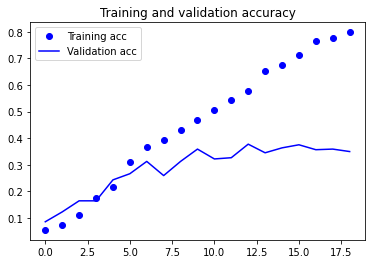

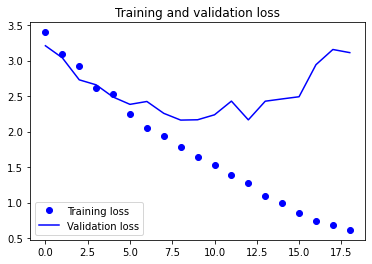

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 32.73%


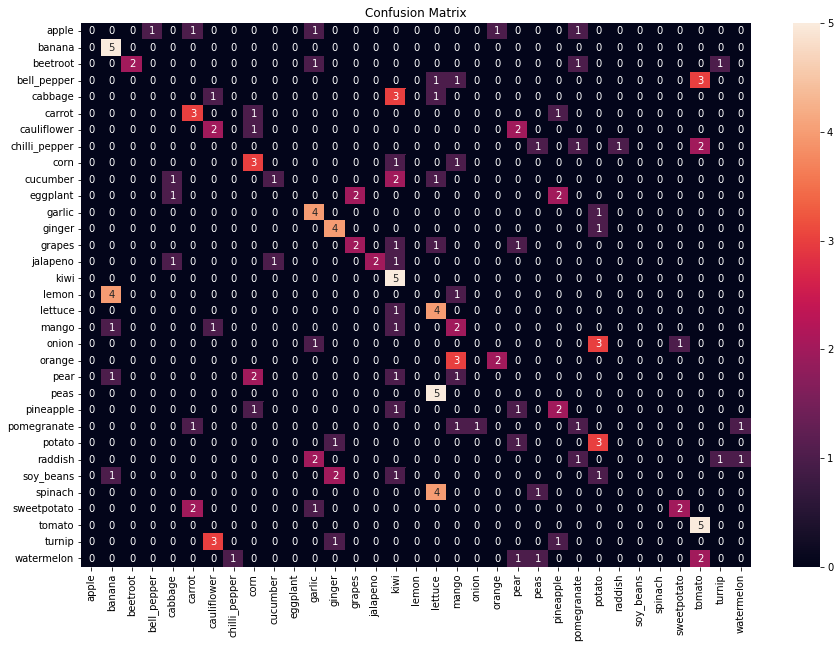

In [ ]:
cf_matrix = confusion_matrix(y_test, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Confusion Matrix')
plt.show()

###Model 1_2a

In [ ]:
#NETWORK ARCHITECTURE

inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = data_augmentation(inputs)                                               #<------ Input augmented
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)   #<----- Added Hidden Layer into output network
outputs = layers.Dense(NUMBER_CLASSES, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 43, 43, 32)       0         
 g2D)                                                      

In [ ]:
PATH_HOME = '/content/drive/Shareddrives/CIDL/'
dir_name = PATH_HOME + "/models"
model_name = 'model2_3-scratch-multiclass.h5'
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,model_name)



earlyStopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=PATIENCE,
                restore_best_weights=True)
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=EPOCH,
    callbacks = [earlyStopping, modelCheckpoint]
)


Epoch 1/40
13/48 [=======>......................] - ETA: 57s - loss: 5.2171 - accuracy: 0.0363

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


46/48 [===========================>..] - ETA: 3s - loss: 3.9874 - accuracy: 0.0356

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


48/48 [==============================] - ETA: 0s - loss: 3.9669 - accuracy: 0.0359
Epoch 00001: val_loss improved from inf to 3.49245, saving model to /content/drive/Shareddrives/CIDL//models/model4-scratch-multiclass.h5
48/48 [==============================] - 99s 2s/step - loss: 3.9669 - accuracy: 0.0359 - val_loss: 3.4924 - val_accuracy: 0.0648
Epoch 2/40
48/48 [==============================] - ETA: 0s - loss: 3.4839 - accuracy: 0.0532
Epoch 00002: val_loss improved from 3.49245 to 3.48626, saving model to /content/drive/Shareddrives/CIDL//models/model4-scratch-multiclass.h5
48/48 [==============================] - 95s 2s/step - loss: 3.4839 - accuracy: 0.0532 - val_loss: 3.4863 - val_accuracy: 0.0648
Epoch 3/40
48/48 [==============================] - ETA: 0s - loss: 3.4818 - accuracy: 0.0573
Epoch 00003: val_loss improved from 3.48626 to 3.48015, saving model to /content/drive/Shareddrives/CIDL//models/model4-scratch-multiclass.h5
48/48 [==============================] - 96s 2s/s

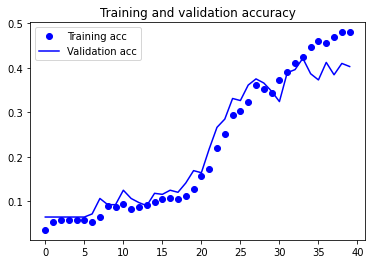

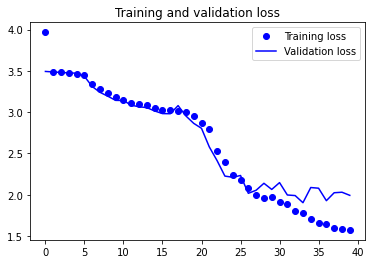

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 40.61%


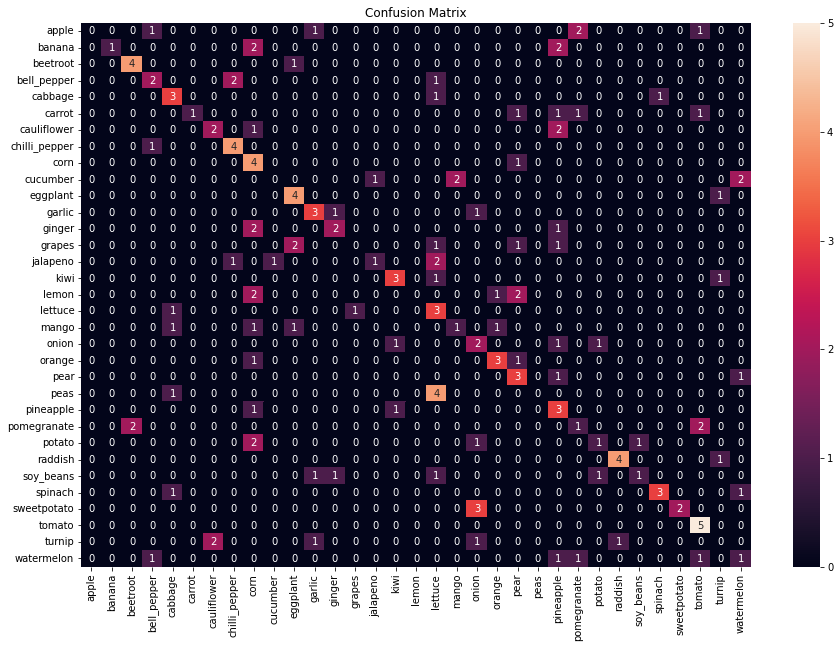

In [ ]:
cf_matrix = confusion_matrix(y_test, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Confusion Matrix')
plt.show()

### Model 2_1a

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

x = data_augmentation(inputs)                                               #<------ Input augmented
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x) 
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)  
x = layers.MaxPooling2D(pool_size=2)(x)  
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)   #<----- Added Hidden Layer into output network
outputs = layers.Dense(NUMBER_CLASSES, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 43, 43, 32)       0         
 g2D)                                                      

In [ ]:
PATH_HOME = '/content/drive/Shareddrives/CIDL/'
dir_name = PATH_HOME + "/models"
model_name = 'model2_1a-scratch-multiclass.h5'
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,model_name)



earlyStopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=PATIENCE,
                restore_best_weights=True)
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=60,
    callbacks = [earlyStopping, modelCheckpoint]
)


Epoch 1/60
17/49 [=========>....................] - ETA: 1:32 - loss: 4.0610 - accuracy: 0.0507

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


31/49 [=================>............] - ETA: 42s - loss: 3.7974 - accuracy: 0.0493

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


49/49 [==============================] - ETA: 0s - loss: 3.6648 - accuracy: 0.0521
Epoch 00001: val_loss improved from inf to 3.39125, saving model to /content/drive/Shareddrives/CIDL//models/model2_1a-scratch-multiclass.h5
49/49 [==============================] - 121s 2s/step - loss: 3.6648 - accuracy: 0.0521 - val_loss: 3.3912 - val_accuracy: 0.0579
Epoch 2/60
49/49 [==============================] - ETA: 0s - loss: 3.2559 - accuracy: 0.0787
Epoch 00002: val_loss improved from 3.39125 to 3.21094, saving model to /content/drive/Shareddrives/CIDL//models/model2_1a-scratch-multiclass.h5
49/49 [==============================] - 93s 2s/step - loss: 3.2559 - accuracy: 0.0787 - val_loss: 3.2109 - val_accuracy: 0.0787
Epoch 3/60
49/49 [==============================] - ETA: 0s - loss: 3.1287 - accuracy: 0.0868
Epoch 00003: val_loss improved from 3.21094 to 3.15626, saving model to /content/drive/Shareddrives/CIDL//models/model2_1a-scratch-multiclass.h5
49/49 [==============================] 

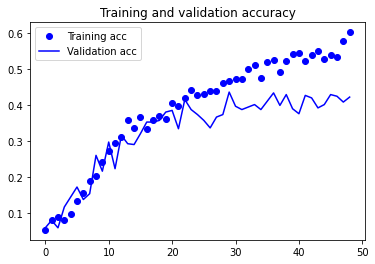

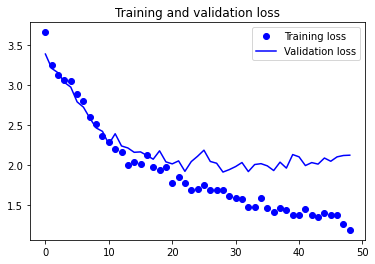

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 38.18%


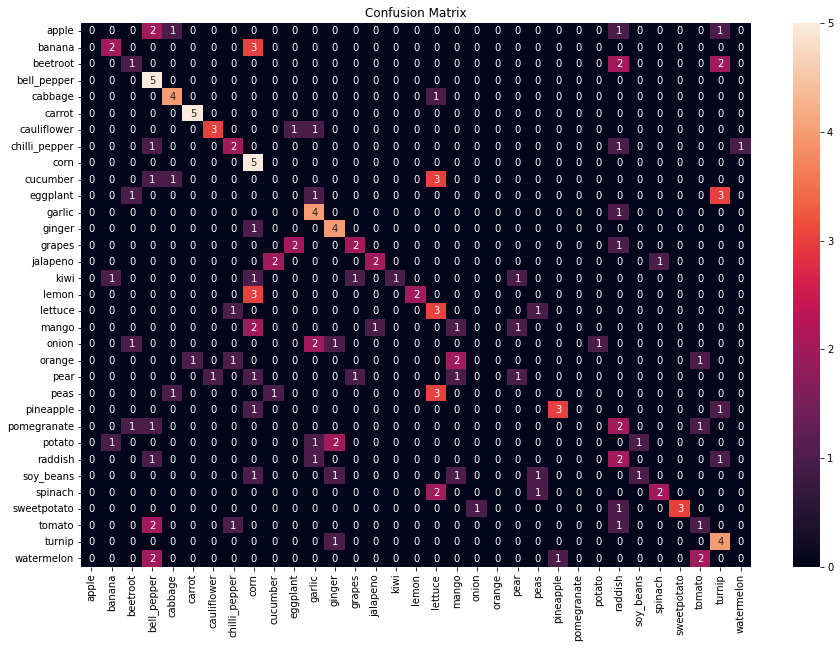

In [ ]:
cf_matrix = confusion_matrix(y_test, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Confusion Matrix')
plt.show()

###Model 2a

In [ ]:
#NETWORK ARCHITECTURE

inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

x = data_augmentation(inputs)                                               #<------ Input augmented
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x) 
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)  
x = layers.Flatten()(x)
outputs = layers.Dense(NUMBER_CLASSES, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                       

In [ ]:
PATH_HOME = '/content/drive/Shareddrives/CIDL/'
dir_name = PATH_HOME + "/models"
model_name = 'model4_3-scratch-multiclass.h5'
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,model_name)



earlyStopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=PATIENCE,
                restore_best_weights=True)
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=60,
    callbacks = [earlyStopping, modelCheckpoint]
)


Epoch 1/60
 1/48 [..............................] - ETA: 2:36 - loss: 6.3627 - accuracy: 0.0278

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/48 [===================>..........] - ETA: 24s - loss: 3.7206 - accuracy: 0.0455

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


48/48 [==============================] - ETA: 0s - loss: 3.6447 - accuracy: 0.0417
Epoch 00001: val_loss improved from inf to 3.48859, saving model to /content/drive/Shareddrives/CIDL//models/model4_3-scratch-multiclass.h5
48/48 [==============================] - 97s 2s/step - loss: 3.6447 - accuracy: 0.0417 - val_loss: 3.4886 - val_accuracy: 0.0486
Epoch 2/60
48/48 [==============================] - ETA: 0s - loss: 3.4535 - accuracy: 0.0660
Epoch 00002: val_loss improved from 3.48859 to 3.31322, saving model to /content/drive/Shareddrives/CIDL//models/model4_3-scratch-multiclass.h5
48/48 [==============================] - 95s 2s/step - loss: 3.4535 - accuracy: 0.0660 - val_loss: 3.3132 - val_accuracy: 0.1088
Epoch 3/60
48/48 [==============================] - ETA: 0s - loss: 3.1868 - accuracy: 0.0828
Epoch 00003: val_loss improved from 3.31322 to 3.09709, saving model to /content/drive/Shareddrives/CIDL//models/model4_3-scratch-multiclass.h5
48/48 [==============================] - 95

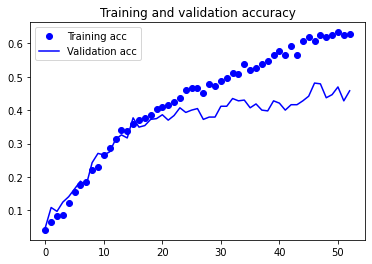

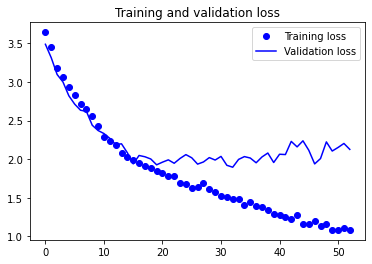

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 43.64%


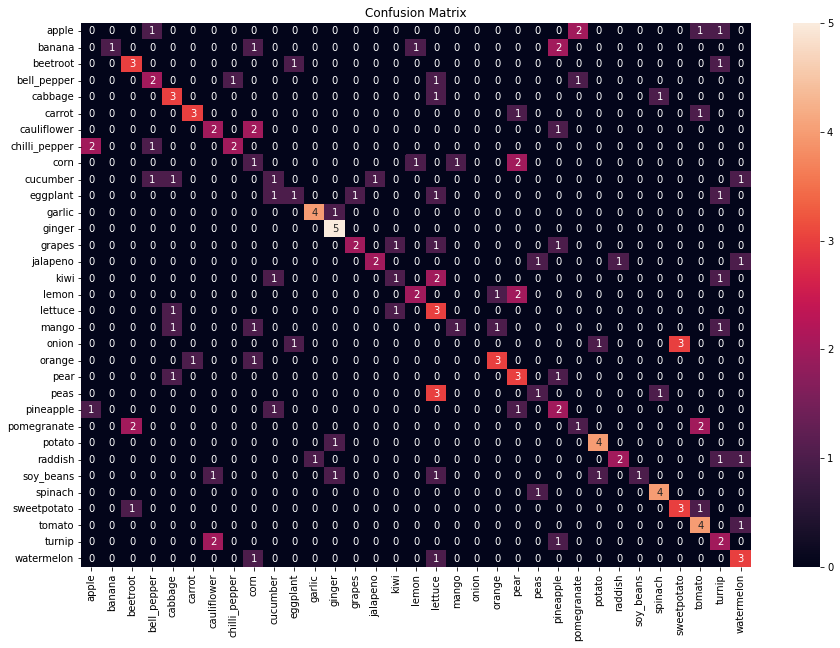

In [ ]:
cf_matrix = confusion_matrix(y_test, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Confusion Matrix')
plt.show()

###Model 1_2aD5

In [ ]:
#NETWORK ARCHITECTURE

inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = data_augmentation(inputs)                                               
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.5)(x)    
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)    
outputs = layers.Dense(NUMBER_CLASSES, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                       

In [ ]:
PATH_HOME = '/content/drive/Shareddrives/CIDL/'
dir_name = PATH_HOME + "/models"
model_name = 'model5a-scratch-multiclass.h5'
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,model_name)



earlyStopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=PATIENCE,
                restore_best_weights=True)
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=60,#EPOCH,
    callbacks = [earlyStopping, modelCheckpoint]
)


Epoch 1/60
13/48 [=======>......................] - ETA: 5:51 - loss: 16.7842 - accuracy: 0.0171

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


45/48 [===========================>..] - ETA: 31s - loss: 7.4169 - accuracy: 0.0358

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


48/48 [==============================] - ETA: 0s - loss: 7.1727 - accuracy: 0.0370 
Epoch 00001: val_loss improved from inf to 3.49434, saving model to /content/drive/Shareddrives/CIDL//models/model5a-scratch-multiclass.h5
48/48 [==============================] - 646s 13s/step - loss: 7.1727 - accuracy: 0.0370 - val_loss: 3.4943 - val_accuracy: 0.0625
Epoch 2/60
48/48 [==============================] - ETA: 0s - loss: 3.4967 - accuracy: 0.0434
Epoch 00002: val_loss improved from 3.49434 to 3.48968, saving model to /content/drive/Shareddrives/CIDL//models/model5a-scratch-multiclass.h5
48/48 [==============================] - 78s 2s/step - loss: 3.4967 - accuracy: 0.0434 - val_loss: 3.4897 - val_accuracy: 0.0625
Epoch 3/60
48/48 [==============================] - ETA: 0s - loss: 3.4899 - accuracy: 0.0440
Epoch 00003: val_loss improved from 3.48968 to 3.48517, saving model to /content/drive/Shareddrives/CIDL//models/model5a-scratch-multiclass.h5
48/48 [==============================] - 78

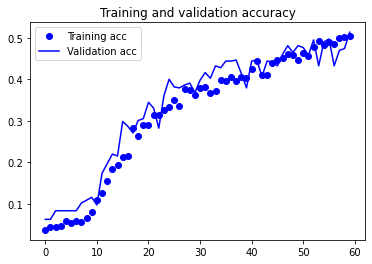

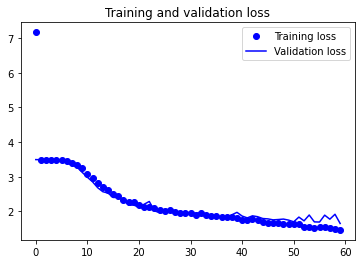

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 47.27%


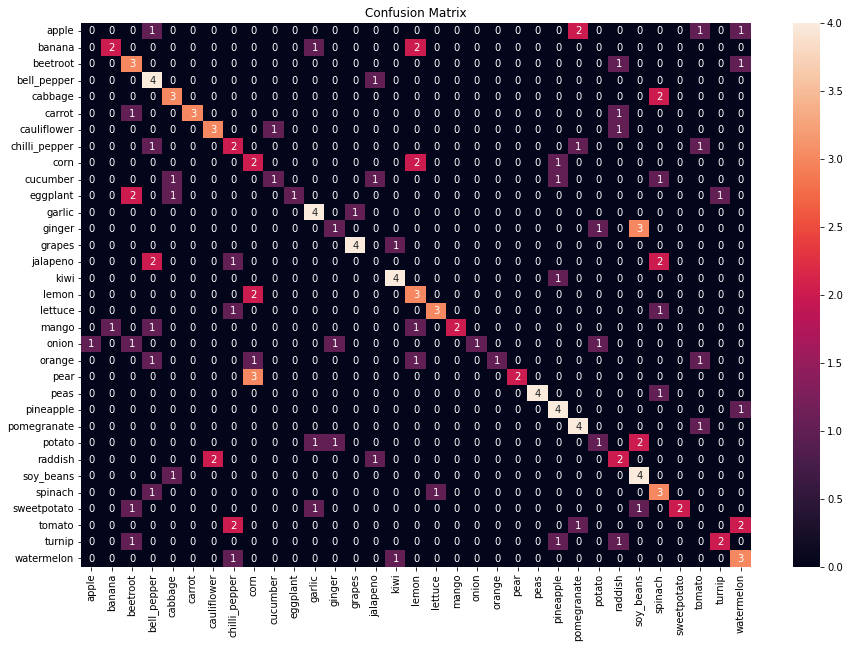

In [ ]:
cf_matrix = confusion_matrix(y_test, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Confusion Matrix')
plt.show()

###Model 1_2aD2

In [ ]:
#NETWORK ARCHITECTURE

inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = data_augmentation(inputs)                                               
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.2)(x)    
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)    
outputs = layers.Dense(NUMBER_CLASSES, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                       

In [ ]:
PATH_HOME = '/content/drive/Shareddrives/CIDL/'
dir_name = PATH_HOME + "/models"
model_name = 'model5b-scratch-multiclass.h5'
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,model_name)



earlyStopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=PATIENCE,
                restore_best_weights=True)
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=60,#EPOCH,
    callbacks = [earlyStopping, modelCheckpoint]
)


Epoch 1/60
16/48 [=========>....................] - ETA: 37s - loss: 8.1054 - accuracy: 0.0365

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


48/48 [==============================] - ETA: 0s - loss: 5.0369 - accuracy: 0.0382
Epoch 00001: val_loss improved from inf to 3.49276, saving model to /content/drive/Shareddrives/CIDL//models/model5b-scratch-multiclass.h5
48/48 [==============================] - 80s 2s/step - loss: 5.0369 - accuracy: 0.0382 - val_loss: 3.4928 - val_accuracy: 0.0625
Epoch 2/60
48/48 [==============================] - ETA: 0s - loss: 3.4895 - accuracy: 0.0480
Epoch 00002: val_loss improved from 3.49276 to 3.48566, saving model to /content/drive/Shareddrives/CIDL//models/model5b-scratch-multiclass.h5
48/48 [==============================] - 78s 2s/step - loss: 3.4895 - accuracy: 0.0480 - val_loss: 3.4857 - val_accuracy: 0.0625
Epoch 3/60
48/48 [==============================] - ETA: 0s - loss: 3.4831 - accuracy: 0.0492
Epoch 00003: val_loss improved from 3.48566 to 3.48083, saving model to /content/drive/Shareddrives/CIDL//models/model5b-scratch-multiclass.h5
48/48 [==============================] - 78s 2

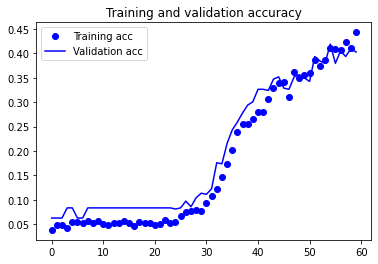

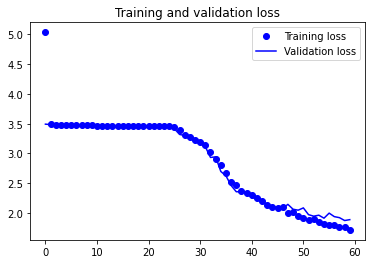

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 35.15%


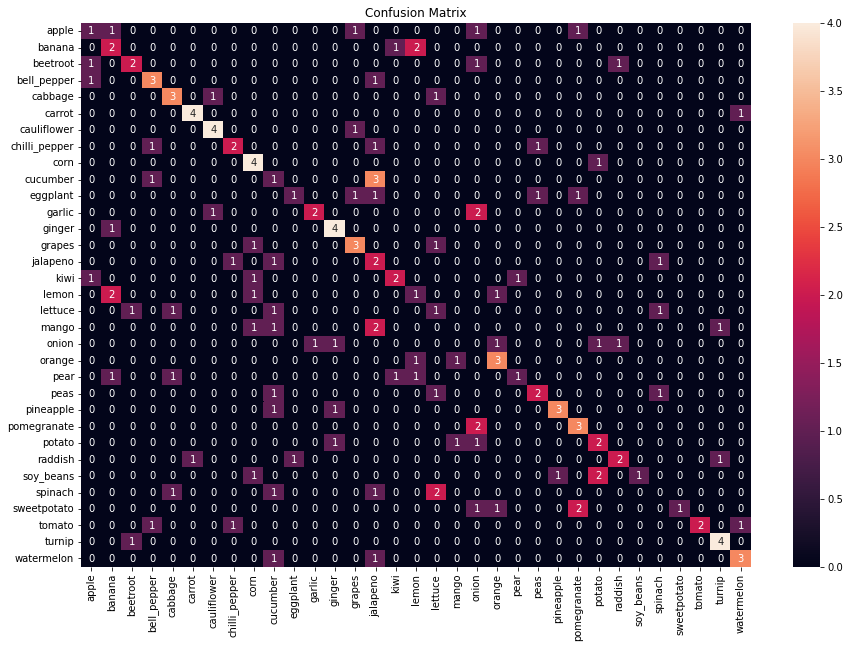

In [ ]:
cf_matrix = confusion_matrix(y_test, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Confusion Matrix')
plt.show()

###Model 2aD5

In [ ]:
#NETWORK ARCHITECTURE

inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

x = data_augmentation(inputs)                                               #<------ Input augmented
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x) 
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.5)(x)    
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)  
x = layers.Flatten()(x)
outputs = layers.Dense(NUMBER_CLASSES, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 43, 43, 32)       0         
 g2D)                                                      

In [ ]:
PATH_HOME = '/content/drive/Shareddrives/CIDL/'
dir_name = PATH_HOME + "/models"
model_name = 'model6a-scratch-multiclass.h5'
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,model_name)



earlyStopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=PATIENCE,
                restore_best_weights=True)
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=80,#EPOCH,
    callbacks = [earlyStopping, modelCheckpoint]
)


Epoch 1/80
 7/48 [===>..........................] - ETA: 49s - loss: 4.3839 - accuracy: 0.0278

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


41/48 [========================>.....] - ETA: 8s - loss: 3.6609 - accuracy: 0.0413 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


48/48 [==============================] - ETA: 0s - loss: 3.6342 - accuracy: 0.0428
Epoch 00001: val_loss improved from inf to 3.45068, saving model to /content/drive/Shareddrives/CIDL//models/model6a-scratch-multiclass.h5
48/48 [==============================] - 81s 2s/step - loss: 3.6342 - accuracy: 0.0428 - val_loss: 3.4507 - val_accuracy: 0.0764
Epoch 2/80
48/48 [==============================] - ETA: 0s - loss: 3.2317 - accuracy: 0.0787
Epoch 00002: val_loss improved from 3.45068 to 2.98047, saving model to /content/drive/Shareddrives/CIDL//models/model6a-scratch-multiclass.h5
48/48 [==============================] - 77s 2s/step - loss: 3.2317 - accuracy: 0.0787 - val_loss: 2.9805 - val_accuracy: 0.1134
Epoch 3/80
48/48 [==============================] - ETA: 0s - loss: 2.8544 - accuracy: 0.1487
Epoch 00003: val_loss improved from 2.98047 to 2.73810, saving model to /content/drive/Shareddrives/CIDL//models/model6a-scratch-multiclass.h5
48/48 [==============================] - 77s 2

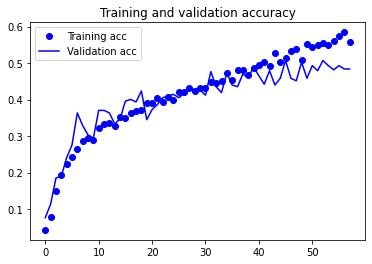

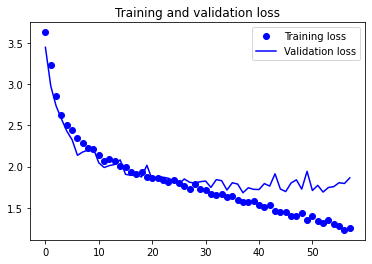

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 47.88%


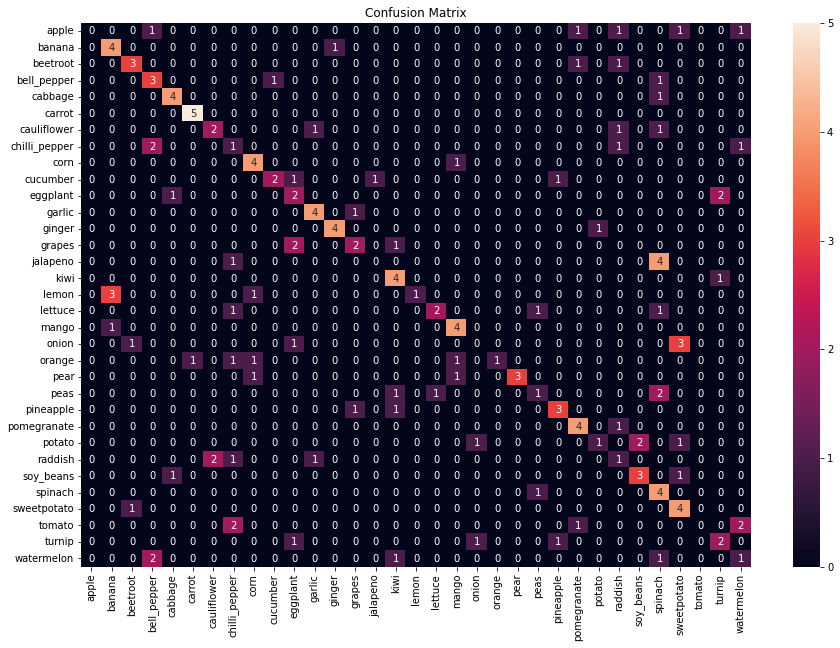

In [ ]:
cf_matrix = confusion_matrix(y_test, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Confusion Matrix')
plt.show()

###Model 2aD2

In [ ]:
#NETWORK ARCHITECTURE

inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

x = data_augmentation(inputs)                                               #<------ Input augmented
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x) 
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.2)(x)    
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)  
x = layers.Flatten()(x)
outputs = layers.Dense(NUMBER_CLASSES, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 43, 43, 32)       0         
 g2D)                                                      

In [ ]:
PATH_HOME = '/content/drive/Shareddrives/CIDL/'
dir_name = PATH_HOME + "/models"
model_name = 'model6b-scratch-multiclass.h5'
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,model_name)



earlyStopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=PATIENCE,
                restore_best_weights=True)
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=80,#EPOCH,
    callbacks = [earlyStopping, modelCheckpoint]
)


Epoch 1/80
23/48 [=============>................] - ETA: 30s - loss: 3.7123 - accuracy: 0.0411

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/48 [===================>..........] - ETA: 18s - loss: 3.6441 - accuracy: 0.0446

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


48/48 [==============================] - ETA: 0s - loss: 3.5983 - accuracy: 0.0457
Epoch 00001: val_loss improved from inf to 3.47452, saving model to /content/drive/Shareddrives/CIDL//models/model6b-scratch-multiclass.h5
48/48 [==============================] - 81s 2s/step - loss: 3.5983 - accuracy: 0.0457 - val_loss: 3.4745 - val_accuracy: 0.0625
Epoch 2/80
48/48 [==============================] - ETA: 0s - loss: 3.2897 - accuracy: 0.0718
Epoch 00002: val_loss improved from 3.47452 to 2.97858, saving model to /content/drive/Shareddrives/CIDL//models/model6b-scratch-multiclass.h5
48/48 [==============================] - 77s 2s/step - loss: 3.2897 - accuracy: 0.0718 - val_loss: 2.9786 - val_accuracy: 0.1505
Epoch 3/80
48/48 [==============================] - ETA: 0s - loss: 2.8600 - accuracy: 0.1383
Epoch 00003: val_loss improved from 2.97858 to 2.81059, saving model to /content/drive/Shareddrives/CIDL//models/model6b-scratch-multiclass.h5
48/48 [==============================] - 77s 2

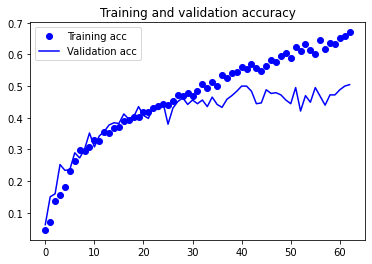

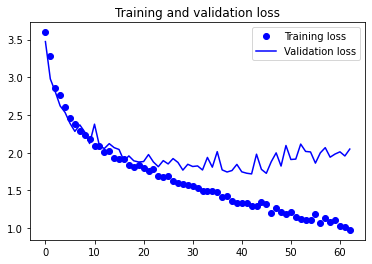

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 49.70%


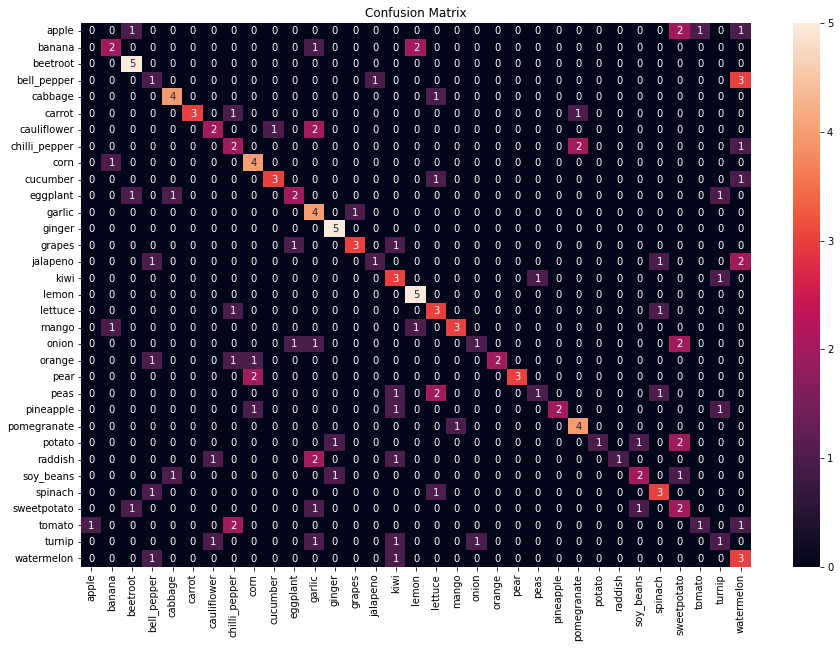

In [ ]:
cf_matrix = confusion_matrix(y_test, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Confusion Matrix')
plt.show()

### Model 1_2aD5L1L2

In [ ]:
#NETWORK ARCHITECTURE

reg = regularizers.l1_l2(l1=1e-5, l2=1e-4)

inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = data_augmentation(inputs)                                               
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.5)(x)    
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu',kernel_regularizer=reg)(x)
x = layers.Dropout(0.5)(x)    
outputs = layers.Dense(NUMBER_CLASSES, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                         

In [ ]:
PATH_HOME = '/content/drive/Shareddrives/CIDL/'
dir_name = PATH_HOME + "/models"
model_name = 'model1_2aD5L1L2-scratch-multiclass.h5'
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,model_name)



earlyStopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=PATIENCE,
                restore_best_weights=True)
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=80,#EPOCH,
    callbacks = [earlyStopping, modelCheckpoint]
)


Epoch 1/80
 4/48 [=>............................] - ETA: 1:12 - loss: 5.3984 - accuracy: 0.0486

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


33/48 [===================>..........] - ETA: 2:16 - loss: 4.0603 - accuracy: 0.0345

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


48/48 [==============================] - ETA: 0s - loss: 3.9517 - accuracy: 0.0411
Epoch 00001: val_loss improved from inf to 3.69567, saving model to /content/drive/Shareddrives/CIDL//models/model1_2aD5L1L2-scratch-multiclass.h5
48/48 [==============================] - 614s 13s/step - loss: 3.9517 - accuracy: 0.0411 - val_loss: 3.6957 - val_accuracy: 0.0556
Epoch 2/80
48/48 [==============================] - ETA: 0s - loss: 3.6092 - accuracy: 0.0619
Epoch 00002: val_loss improved from 3.69567 to 3.51814, saving model to /content/drive/Shareddrives/CIDL//models/model1_2aD5L1L2-scratch-multiclass.h5
48/48 [==============================] - 88s 2s/step - loss: 3.6092 - accuracy: 0.0619 - val_loss: 3.5181 - val_accuracy: 0.0556
Epoch 3/80
48/48 [==============================] - ETA: 0s - loss: 3.4910 - accuracy: 0.0816
Epoch 00003: val_loss improved from 3.51814 to 3.45917, saving model to /content/drive/Shareddrives/CIDL//models/model1_2aD5L1L2-scratch-multiclass.h5
48/48 [=============

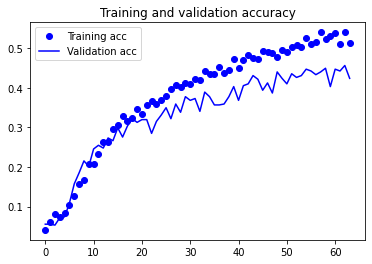

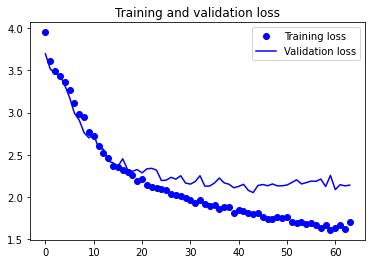

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 43.03%


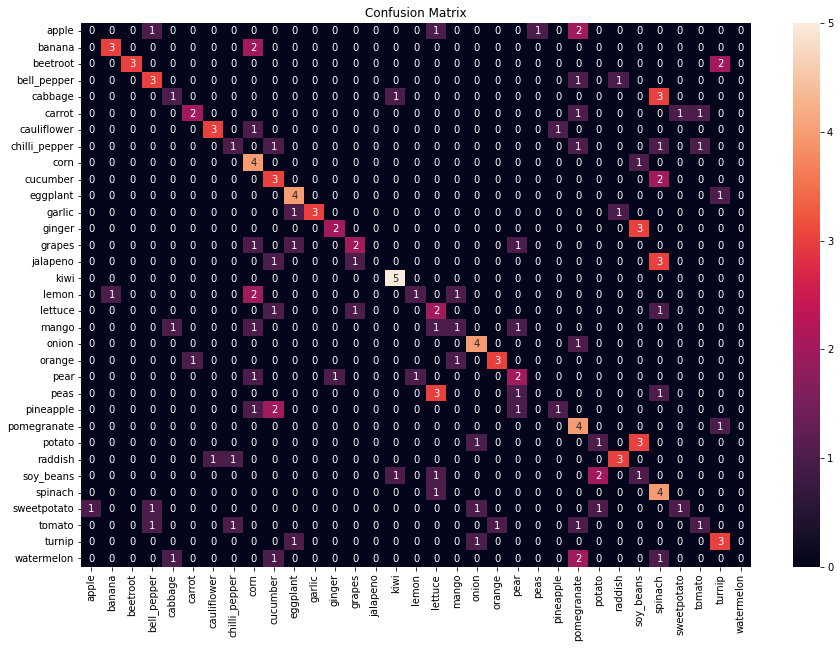

In [ ]:
cf_matrix = confusion_matrix(y_test, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Confusion Matrix')
plt.show()

### Model 2aD2L1L2

In [ ]:
#NETWORK ARCHITECTURE

reg = regularizers.l1_l2(l1=1e-5, l2=1e-4)

inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

x = data_augmentation(inputs)                                               #<------ Input augmented
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x) 
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.2)(x)    
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu',kernel_regularizer=reg)(x)  
x = layers.Dropout(0.2)(x)   
outputs = layers.Dense(NUMBER_CLASSES, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                       

In [ ]:
PATH_HOME = '/content/drive/Shareddrives/CIDL/'
dir_name = PATH_HOME + "/models"
model_name = 'model2aD2L1L2-scratch-multiclass.h5'
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name,model_name)



earlyStopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=PATIENCE,
                restore_best_weights=True)
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(
                      filepath=save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=80,#EPOCH,
    callbacks = [earlyStopping, modelCheckpoint]
)


Epoch 1/80
 3/48 [>.............................] - ETA: 57s - loss: 10.0328 - accuracy: 0.0093    

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


23/48 [=============>................] - ETA: 36s - loss: 4.9255 - accuracy: 0.0399

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


48/48 [==============================] - ETA: 0s - loss: 4.4155 - accuracy: 0.0463
Epoch 00001: val_loss improved from inf to 3.91849, saving model to /content/drive/Shareddrives/CIDL//models/model2aD2L1L2-scratch-multiclass.h5
48/48 [==============================] - 91s 2s/step - loss: 4.4155 - accuracy: 0.0463 - val_loss: 3.9185 - val_accuracy: 0.0556
Epoch 2/80
48/48 [==============================] - ETA: 0s - loss: 3.8561 - accuracy: 0.0567
Epoch 00002: val_loss improved from 3.91849 to 3.74674, saving model to /content/drive/Shareddrives/CIDL//models/model2aD2L1L2-scratch-multiclass.h5
48/48 [==============================] - 89s 2s/step - loss: 3.8561 - accuracy: 0.0567 - val_loss: 3.7467 - val_accuracy: 0.0556
Epoch 3/80
48/48 [==============================] - ETA: 0s - loss: 3.5857 - accuracy: 0.0764
Epoch 00003: val_loss improved from 3.74674 to 3.48995, saving model to /content/drive/Shareddrives/CIDL//models/model2aD2L1L2-scratch-multiclass.h5
48/48 [=====================

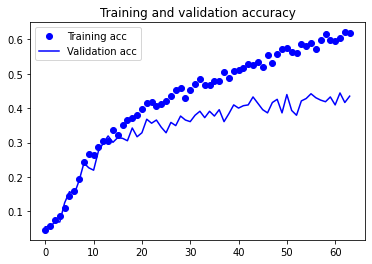

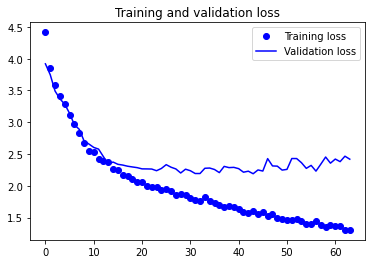

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 40.61%


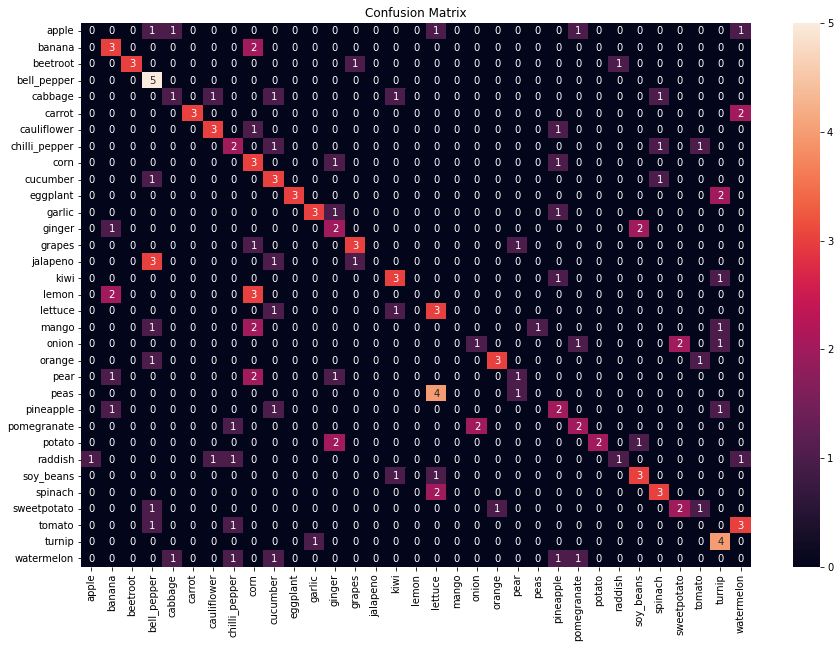

In [ ]:
cf_matrix = confusion_matrix(y_test, pred, normalize=None)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Confusion Matrix')
plt.show()